17-6. 프로젝트 - Movielens 영화 SBR
===
---

### 목표
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보자.

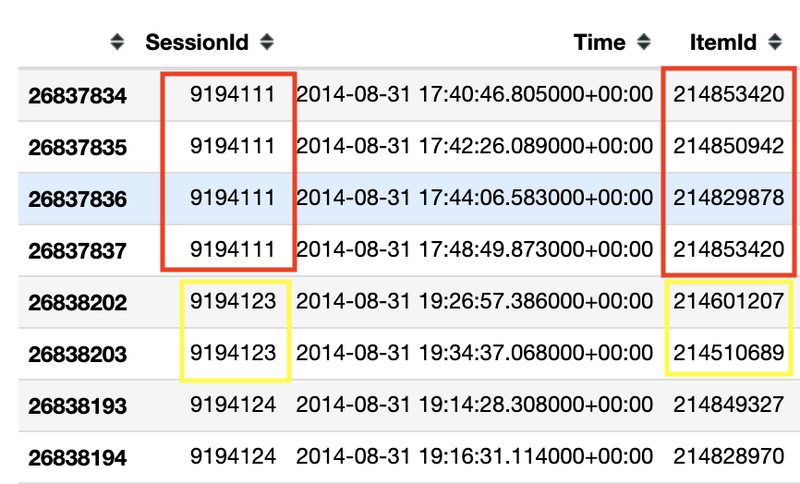

### 데이터셋 정보

[데이터 정보](https://biology-statistics-programming.tistory.com/47?category=955669)

### 목차

라이브러리 설정 <br/>
데이터 path 설정 및 불러오기

**Step1. 데이터의 전처리**

    - 세션 수와 아이템 수를 확인!
    - rating이 3보다 낮으면 삭제!
    - 클릭수 별 유저의 분포 시각화
    - 클릭수 별 유저의 분포 확인
    - 유저 당 클릭 수의 중앙값과 평균
    - 유저의 클릭 수의 최소값과 최대값
    - 99.9%에서의 유저의 클릭 수
    - UserID별 클릭 수 확인
    - UserID별 클릭 수 확인 시각화
    - 가장 오래된 시간과 가장 최근 시간 출력
    - 데이터를 나눠주는 함수
    - 함수를 적용해서 Train, Validation, Test로 나누기
    - data에 대한 정보를 보기 위한 함수
    - Train, Validation, Test에 대해서 살펴보기
    - Train data를 기준으로 인덱싱하기
    - 데이터를 저장하기

**Step 2. 미니 배치의 구성**

    - SessionDatset 클래스를 정의
    - 인덱싱을 부여한 데이터셋을 출력하기
    - 데이터셋의 인덱스 출력
    - 데이터셋의 인덱스에 대한 클릭수 누적
    - SessionDataLoader 설정
    - UserId를 기준으로 Sort
    - 데이터 로더에 대해서 iter 함수를 적용
    - next함수를 적용

**Step 3. 모델 구성**

    - Evaluation Metric 만들기 :: 모델 평가를 위한 지표
    - 모델 구성을 위한 라이브러리
    - create_model 함수를 정의하기
    - 모델을 사용할 Hyher-parameter를 class형식으로 관리하기
    - 모델 만들기
        - base 모델
        - 변화1. epoch을 늘려보기 (3 -> 5)
        - 변화2. drop_rate를 늘려보기 (0.1 -> 0.3)
        - 변화3. batch_size를 줄여보기 (64 -> 32)
    - train model 만드는 함수 정의

**Step 4. 모델 학습**

    - base모델 학습
    - 변화1 학습
    - 변화2 학습
    - 변화3 학습

**Step 5. 모델 테스트**

    - base모델 테스트
    - 변화1 테스트
    - 변화2 테스트
    - 변화3 테스트
    
**분석**

**회고**

**루브릭**
    

<br/>
<br/>
<br/>
<br/>



### 라이브러리 설정

In [1]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### 데이터 path 설정 및 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Step 1. 데이터의 전처리
---
### 세션 수와 아이템 수를 확인!

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### rating이 3보다 낮으면 삭제!

In [4]:
data1 = data[data['Rating'] > 2]
data1

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 클릭수 별 유저의 분포 시각화

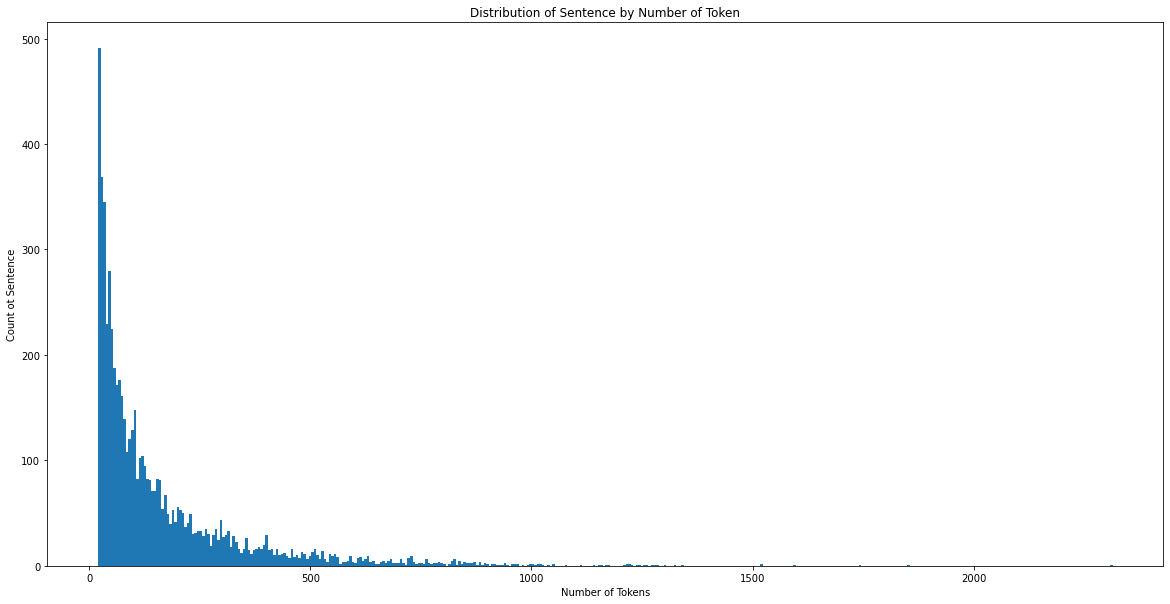

In [5]:
from collections import Counter

User_length = data.groupby('UserId').size()
user_len = []
for user_leng in User_length:
    user_len.append(user_leng)

plt.figure(figsize=(20, 10))
plt.hist(user_len, range = (20,2314), bins = 400)  # 히스토그램 설정
plt.xlabel('Number of Tokens')  # x축 이름 설정
plt.ylabel('Count ot Sentence')  # y축 이름 설정
plt.title('Distribution of Sentence by Number of Token')  # 히스토그램 이름 설정
plt.show()


### 클릭수 별 유저의 분포 확인

In [6]:
Counter(sorted(user_len))    

Counter({20: 86,
         21: 91,
         22: 77,
         23: 81,
         24: 81,
         25: 75,
         26: 62,
         27: 66,
         28: 60,
         29: 72,
         30: 58,
         31: 51,
         32: 55,
         33: 62,
         34: 44,
         35: 58,
         36: 71,
         37: 55,
         38: 49,
         39: 49,
         40: 48,
         41: 48,
         42: 35,
         43: 48,
         44: 40,
         45: 40,
         46: 46,
         47: 55,
         48: 51,
         49: 29,
         50: 50,
         51: 42,
         52: 39,
         53: 35,
         54: 30,
         55: 38,
         56: 27,
         57: 40,
         58: 31,
         59: 27,
         60: 25,
         61: 33,
         62: 45,
         63: 22,
         64: 42,
         65: 29,
         66: 25,
         67: 35,
         68: 28,
         69: 23,
         70: 33,
         71: 32,
         72: 29,
         73: 26,
         74: 29,
         75: 20,
         76: 26,
         77: 31,
         78: 2

### 유저 당 클릭 수의 중앙값과 평균

In [7]:
User_length.median(), User_length.mean()

(96.0, 165.5975165562914)

### 유저의 클릭 수의 최소값과 최대값

In [8]:
User_length.min(), User_length.max()

(20, 2314)

### 99.9%에서의 유저의 클릭 수

In [9]:
User_length.quantile(0.999)

1343.181000000005

### UserID별 클릭 수 확인

In [10]:
User_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

### UserID별 클릭 수 확인 시각화

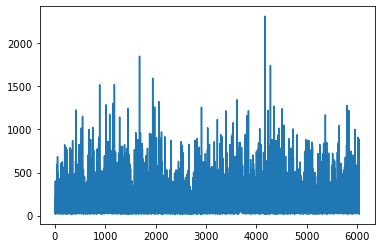

In [11]:
plt.plot(User_length)

### 가장 오래된 시간과 가장 최근 시간 출력

In [12]:
oldest, latest = data1['Time'].min(), data1['Time'].max()
print('가장 오래전 시간',oldest) 
print('가장 최근 시간',latest)

print('약', (latest-oldest)/(365*24*60*60), '년간의 데이터')

가장 오래전 시간 956703932
가장 최근 시간 1046454590
약 2.845974695585997 년간의 데이터


### 데이터를 나눠주는 함수

In [13]:
def split_by_date(data: pd.DataFrame):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - 3*30*24*60*60].index
    session_in_test = session_last_time[session_last_time >= final_time - 3*30*24*60*60].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

약 3년간의 데이터 이므로 Test는 3개월(3X30X24X60X60)간의 데이터를 사용하기로 하고 나머지를 Train data로 이와 동일한 비율로 Validation과 Train으로 나누자

### 함수를 적용해서 Train, Validation, Test로 나누기

In [14]:
tr, test = split_by_date(data1)
tr, val = split_by_date(tr)

### data에 대한 정보를 보기 위한 함수

In [15]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t ID: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

###  Train, Validation, Test에 대해서 살펴보기

In [16]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 722294
	 ID: 5706
	 Items: 3603
	 First Time : 956703932
	 Last Time : 1030839253

* valid Set Stats Info
	 Events: 33561
	 ID: 103
	 Items: 2865
	 First Time : 956853488
	 Last Time : 1038664052

* test Set Stats Info
	 Events: 80592
	 ID: 230
	 Items: 3211
	 First Time : 957179713
	 Last Time : 1046454590



### Train data를 기준으로 인덱싱하기

In [17]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

### 데이터를 저장하기

In [18]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
---

### SessionDatset 클래스를 정의

In [19]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

### 인덱싱을 부여한 데이터셋을 출력하기

In [20]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


### 데이터셋의 인덱스 출력 

In [21]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5703, 5704, 5705])

### 데이터셋의 인덱스에 대한 클릭수 누적

In [22]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 721899, 722018, 722294], dtype=int32)

### SessionDataLoader 설정

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듦

In [23]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

### UserId를 기준으로 Sort

In [24]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


### 데이터 로더에 대해서 iter 함수를 적용

In [25]:
iter_ex = iter(tr_data_loader)

### next함수를 적용

In [26]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


> 모델의 인풋, 라벨, 세션에 대해서 끝나는 곳의 위치를 yield한 결과이다. <br/>
mask는 RNN Cell State를 초기화하는데 사용될 예정이다.

<br/>

# Step 3. 모델 구성
---
### Evaluation Metric 만들기 :: 모델 평가를 위한 지표

In [27]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 모델 구성을 위한 라이브러리

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

### create_model 함수를 정의하기

In [29]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

### 모델을 사용할 Hyher-parameter를 class형식으로 관리하기

In [30]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 모델 만들기

### base 모델

In [31]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3603)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      548250    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3603)                183753    
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________


### 변화1. epoch을 늘려보기 (3 -> 5)

In [32]:
args1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3603)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      548250    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3603)                183753    
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________


### 변화2. drop_rate를 늘려보기 (0.1 -> 0.3)

In [33]:
args2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=3, k=20)

model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3603)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      548250    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3603)                183753    
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________


### 변화3. batch_size를 줄여보기 (64 -> 32)

In [34]:
args3 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

model3 = create_model(args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3603)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      548250    
_________________________________________________________________
dropout_3 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (32, 3603)                183753    
Total params: 732,003
Trainable params: 732,003
Non-trainable params: 0
_________________________________________________________________


### train model 만드는 함수 정의

In [35]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# Step 4. 모델 학습
---

### base모델 학습

In [36]:
train_model(model, args)

Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.73]

	 - Recall@20 epoch 1: 0.239939
	 - MRR@20    epoch 1: 0.060292



Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.4]  

	 - Recall@20 epoch 2: 0.283498
	 - MRR@20    epoch 2: 0.077582



Evaluation:  53%|█████▎    | 278/522 [01:04<00:56,  4.32it/s]

	 - Recall@20 epoch 3: 0.299573
	 - MRR@20    epoch 3: 0.085016



### 변화1 학습

In [37]:
train_model(model1, args1)

Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.66]

	 - Recall@20 epoch 1: 0.237073
	 - MRR@20    epoch 1: 0.060175



Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.69]

	 - Recall@20 epoch 2: 0.283835
	 - MRR@20    epoch 2: 0.076783



Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.141, train_loss=5.2]  

	 - Recall@20 epoch 3: 0.298674
	 - MRR@20    epoch 3: 0.084069



Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.56]

	 - Recall@20 epoch 4: 0.305474
	 - MRR@20    epoch 4: 0.088226



Evaluation:  53%|█████▎    | 278/522 [01:04<00:56,  4.33it/s]

	 - Recall@20 epoch 5: 0.309296
	 - MRR@20    epoch 5: 0.091195



### 변화2 학습

In [38]:
train_model(model2, args2)

Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.83]

	 - Recall@20 epoch 1: 0.227406
	 - MRR@20    epoch 1: 0.056697



Train:   0%|          | 0/11196 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.42]

	 - Recall@20 epoch 2: 0.275517
	 - MRR@20    epoch 2: 0.075563



Evaluation:  53%|█████▎    | 278/522 [01:04<00:56,  4.33it/s]

	 - Recall@20 epoch 3: 0.295751
	 - MRR@20    epoch 3: 0.081984



### 변화3 학습

In [39]:
train_model(model3, args3)

Train:   0%|          | 0/22393 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6]   

	 - Recall@20 epoch 1: 0.234178
	 - MRR@20    epoch 1: 0.060706



Train:   0%|          | 0/22393 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.69]

	 - Recall@20 epoch 2: 0.270084
	 - MRR@20    epoch 2: 0.073753



Evaluation:  76%|███████▌  | 792/1045 [01:36<00:30,  8.22it/s]

	 - Recall@20 epoch 3: 0.279198
	 - MRR@20    epoch 3: 0.078506



# Step 5. 모델 테스트
---
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### base 모델 학습

In [41]:
test_model(model, args, test)

Evaluation:  78%|███████▊  | 984/1255 [03:39<01:00,  4.48it/s]

	 - Recall@20: 0.247761
	 - MRR@20: 0.069052




### 변화 1 모델 학습

In [42]:
test_model(model1, args1, test)

Evaluation:  78%|███████▊  | 984/1255 [03:38<01:00,  4.51it/s]

	 - Recall@20: 0.256780
	 - MRR@20: 0.073736



### 변화 2 모델 학습

In [43]:
test_model(model2, args2, test)

Evaluation:  78%|███████▊  | 984/1255 [03:40<01:00,  4.46it/s]

	 - Recall@20: 0.241918
	 - MRR@20: 0.066195



### 변화 3 모델 학습

In [44]:
test_model(model3, args3, test)

Evaluation:  90%|█████████ | 2267/2511 [04:40<00:30,  8.08it/s]

	 - Recall@20: 0.242735
	 - MRR@20: 0.068539



## 변화 분석
---

||base|변화1(epoch 3-> 5)|변화2(drop_rate 0.1 -> 0.3)|변화3 (batch_size 64 -> 32)|
|:---:|:---:|:---:|:---:|:---:|
|train loss의 변화|5.9 -> 5.43|5.88 -> 5.21|6.2 -> 5.53|5.87 -> 5.6|
|Recall|0.247761|0.256780|0.241918|0.242735|
|MRR|0.069052|0.073736|0.066195|0.068539|

**Recall**
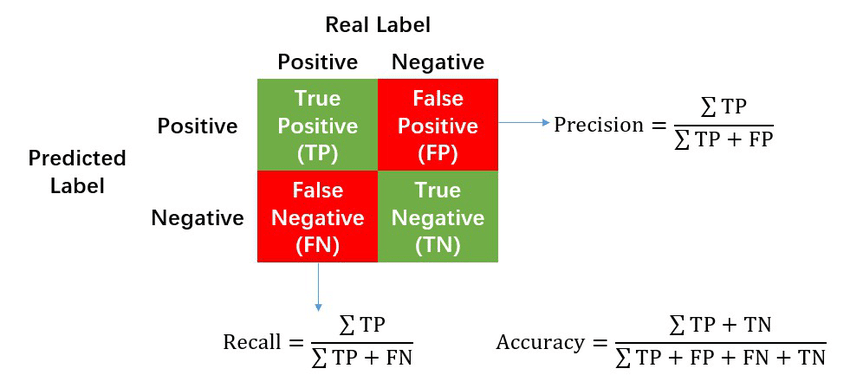
[이미지 출처](https://www.researchgate.net/figure/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix_fig3_336402347)

**설명**
> Recall은 참이라고 예측한 것 중에서 실제 참인 것의 비율을 의미한다. 이는 양성을 음성으로 판단하면 안되는 민감한 사항들에 대해서 중요한 지표가 된다. 이를 이번 노드에 적용해서 해석해보자면 관심없는 영화가 관심목록에 뜨는 것은 상관이 없지만 관심있는 영화가 관심목록에 빠지는 것은 치명적일 수 있다. 따라서 Recall이 중요한 지표가 될 수 있다.  

**MRR**
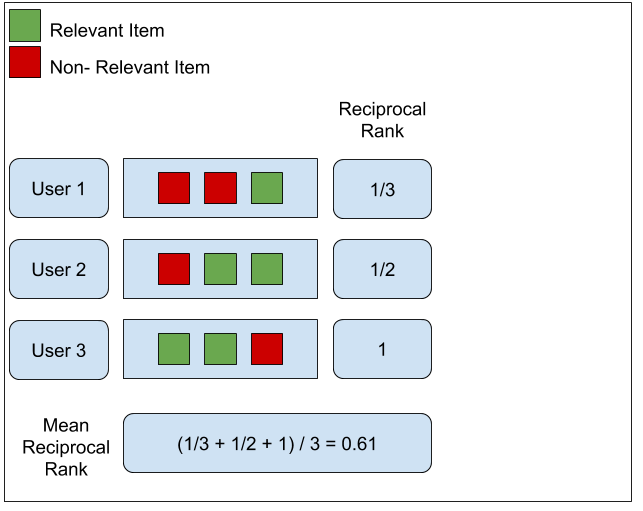

$$ MRR = \frac{1}{N}\sum_{i=1}^{N}\frac{1}{rank_{i}} $$

[이미지 출처](https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)

**설명**
> MRR은 우선순위를 고려한 평가기준 중 가장 간단한 모델로 다음과 같은 알고리즘을 사용한다고 한다.
> - 각 사용자마다 제공한 추천 컨텐츠 중 관련있는 컨텐츠 중 가장 높은 위치를 역수로 계산한다.
> - 사용자마다 계산된 점수를 모아 평균을 계산한다.
> 즉, MRR은 오직, 가장 상위의 관련 컨텐츠의 위치만을 고려하여 점수를 계산함으로써 가장 관련있는 컨텐츠가 얼마나 상위에 올라가 있는지를 평가한다.

[내용참고](https://lamttic.github.io/2020/03/20/01.html)


**판단**
- epoch는 3보다 늘리는 것이 좋은 것으로 보인다.
- drop rate는 0.1보다 커지면 좋지 않은 것으로 보인다.
- batch size는 64보다 작아지면 좋지 않은 것으로 보인다.


<br/>
<br/>

## 회고
---

**index 103 is out of bounds for axis 0 with size 103 에러 해결**

> batch size의 의미는 한 에폭을 도는 동안 batch size만큼씩 뽑아서 반복한다는 것이다. 즉, batch size를 줄이면 한 에폭을 도는 시간이 길어진다. User_Id의 개수는 5000여개 정도 밖에 되지 않았고 이마저도 Split해주면 더 줄 것이다. validation에서의 UserId의 index는 103까지였으으므로 이보다 작은 batch_size인 64를 넣어주어야 오류가 나지 않았다.

**Time이 초단위로 주어진 것에 대한 문제**

> 초 단위로 시간(기간)을 계산하여 해결하였다. ex) 3개월 = 3(개월)x24(시간)x60(분)x60(초)
 
<br/>
<br/>

## 루브릭
---


**데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.**

> 3년의 데이터, 3개월로 끊어 test, validation으로 사용


**적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.**

> 모델 학습에서 확인 가능

**3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.**

> 변화 1, 2, 3을 통해 확인 가능